# Lyrics classifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from scipy import sparse
import string 
punctuation_set = set(string.punctuation)

from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 
import langid

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

In [3]:
data = pd.read_csv('lyrics.csv')

In [4]:
data.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [5]:
print('Shape of the dataframe: {}'.format(data.shape))

Shape of the dataframe: (362237, 6)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
index     362237 non-null int64
song      362235 non-null object
year      362237 non-null int64
artist    362237 non-null object
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


In [7]:
data = data.drop('index',axis=1) # the index column is redundant

In [8]:
year_dist = data.year.value_counts()
print(year_dist.head())
print('Oldest song belongs to the year: {}'.format(year_dist.index.min()))
print('Latest song belongs to the year: {}'.format(year_dist.index.max()))

2006    76590
2007    63677
2016    37409
2015    28766
2014    28250
Name: year, dtype: int64
Oldest song belongs to the year: 67
Latest song belongs to the year: 2038


- Clearly there is something odd there!

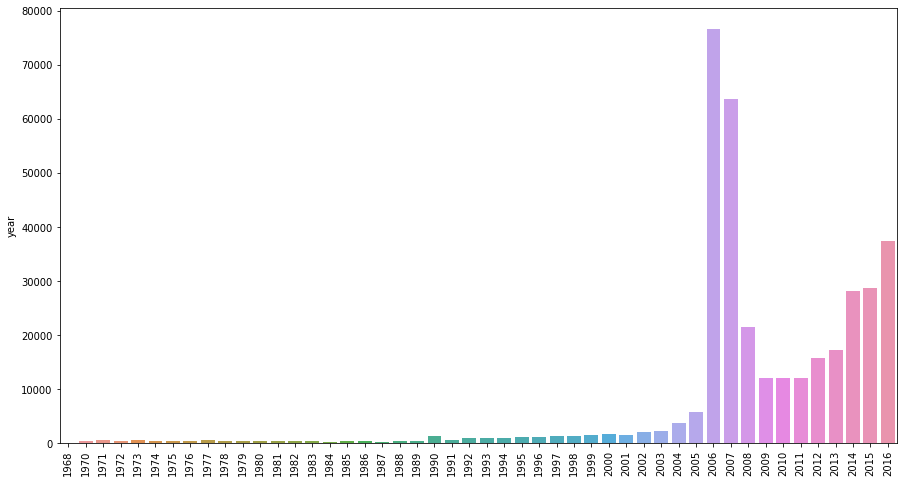

In [9]:
year_dist = year_dist.iloc[(year_dist.index>1900) & (year_dist.index <2019)]
plt.figure(figsize=(15,8))
_=sns.barplot(year_dist.index, year_dist)
_=plt.xticks(rotation='vertical')

In [10]:
print('There are {} rows with missing lyrics.'.format(data.lyrics.isna().sum()))
data.loc[data.lyrics.isna()].head()

There are 95680 rows with missing lyrics.


,song,year,artist,genre,lyrics
158,lemonade,2016,beyonce-knowles,Pop,NaN
305,no-more-tears,2002,eazy-e,Hip-Hop,NaN
311,still-f-kem,2002,eazy-e,Hip-Hop,NaN
320,rev-skit,2002,eazy-e,Hip-Hop,NaN
338,hush-hush,2013,asher-monroe,Pop,NaN


#### There is no point keeping the rows with missing lyrics because the point of this notebook is to analyze the lyrics of the songs and classify them. Therefore let's remove all the rows with missing lyrics.

In [11]:
data = data.dropna(axis=0, subset=['lyrics','song'])

In [12]:
data.shape

(266556, 5)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 5 columns):
song      266556 non-null object
year      266556 non-null int64
artist    266556 non-null object
genre     266556 non-null object
lyrics    266556 non-null object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


- No more missing values, Good to go!

### Distribution of the music genres
- Since we are interested in predicting the genre from the lyrics and other metadata available, let us first explore the 'target variable', i.e. the genre.

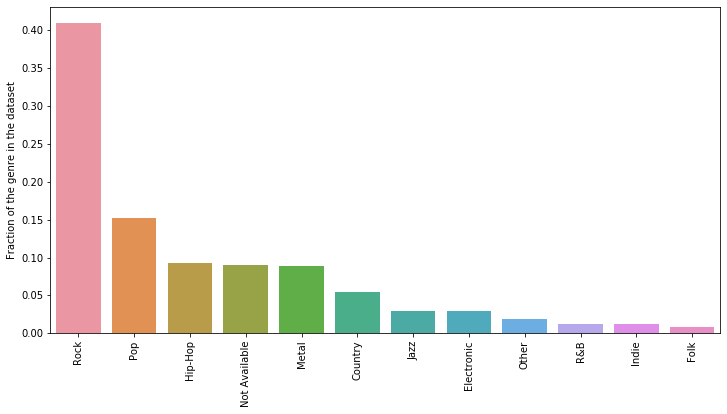

In [14]:
genre_count = data.genre.value_counts()
plt.figure(figsize=(12,6))
_=sns.barplot(genre_count.index, genre_count/len(data))
_=plt.xticks(rotation='vertical')
_=plt.ylabel('Fraction of the genre in the dataset')

- The dataset is highly imbalanced with respect to genre. 
 * More than 40% of the songs are rock, while less than 1% are folk songs. Says a lot about music preferences across the world in general? Mind you that the dataset is not restricted to English songs, it contains German, French and Spanish songs also.

In [15]:
# Filter out the rows that contain lyrics with less than 200 characters and genre is not available

data = data.loc[data.lyrics.map(len)> 200]
data = data.loc[~(data.genre == 'Not Available')]

In [16]:
data.shape

(234296, 5)

### Who are the top 10 artists?

In [17]:
pd.DataFrame(data.artist.value_counts()[:10])

,artist
dolly-parton,743
elton-john,643
chris-brown,621
barbra-streisand,602
eddy-arnold,589
bee-gees,586
bob-dylan,584
eminem,567
ella-fitzgerald,565
american-idol,562


### Data pre-processing

Next I would like to filter out all the non-English lyrics from the dataset to keep it simple.
- The number of non-English songs in the dataset is much smaller than that of English songs.
- It might introduce noise during song classification.
- Topic modelling, understandably separates out the different languages.

In [18]:
def is_english_lyrics(text):
    lang_clf = langid.classify(text)[0]
    eng_text =  lang_clf=='en'
    if eng_text:
        return 1
    else:
        return 0

In [160]:
data['english_lyrics'] = data['lyrics'].apply(lambda lyrics: is_english_lyrics(lyrics))

In [170]:
print('{} songs have English lyrics in the dataset'.format(data['english_lyrics'].sum()))  #How many songs have English lyrics

211401 songs have English lyrics in the dataset


In [162]:
data = data.loc[data['english_lyrics']==1, :].reset_index(drop=True)

In [163]:
#from polyglot.detect import Detector

In [164]:
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german'))).union(set(stopwords.words('spanish'))).union(set(stopwords.words('french')))  
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(lyrics):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [word for word in tokenizer.tokenize(lyrics.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if len(word)>2]
#    clean_words = [word for word in words if word not in punctuation_set] #remove puntuations
    lemmatized_lyrics = ' '.join([lemmatizer.lemmatize(word,pos= get_wordnet_pos(word)) for word in clean_words]) ## lemmatization
    return lemmatized_lyrics         

- We will now apply the preprocessing function to transform the 'lyrics' column.

In [165]:
start = time.time()
data['lyrics'] = data['lyrics'].apply(lambda lyrics: preprocess_text(lyrics))
print('Took {} secs.'.format(time.time() - start))

Took 4055.602637052536 secs.


- Only keep those lyrics which contain at least twenty words.

In [166]:
data = data.loc[data['lyrics'].apply(lambda words: len(words.split()))>20, :].reset_index(drop=True)

In [167]:
data.to_pickle("preprocessed_data.pkl")
#data = pd.read_pickle("preprocessed_data.pkl")

In [150]:
# Take a peek in to the cleaned lyrics column
clean_lyrics = data['lyrics']
clean_lyrics.head(10)

0    baby know gonna cut right chase woman make lik...
1    playin everything easy like seem sure still wa...
2    search tenderness hard find love need live loo...
3    verse write book stand title book would life s...
4    party people people party pop sit around see l...
5    heard church bell ring heard choir sing saw lo...
6    another day would spend waitin right one star ...
7    wait wait wait wait wait wait wait wait wait w...
8    verse read magazine wait around say wait see g...
9    honey well sit look around cause must bumped h...
Name: lyrics, dtype: object

## Topic modelling with Latent Dirichlet Allocation (LDA)
- The purpose of this section is to see if the unsupervised algorithm can separate up the genres based on the lyrics alone. That would be super cool! Let's find out.

In [151]:
tokenized_clean_lyrics = [word_tokenize(doc) for doc in clean_lyrics]
gensim_dict = Dictionary(tokenized_clean_lyrics)
gensim_dict.save('dictionary.dict')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [152]:
#Now convert each document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_clean_lyrics]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

#### LDA with count features
- We will create a LDA model with 10 topics (ambitious attempt). Why 10? Because there are 10 different genres in the dataset.

In [155]:
num_topics=10
start = time.time()
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics, chunksize=10000)
lda.save('lda_10_topics.ldamodel')
print((time.time() - start)/60, 'mins')

3.568079650402069 mins


In [205]:
def show_topics(model,num_topics=10):
    ''' Input: LDA model, number of topics to display (default=5).
    Output: dataframe with topics as columns
    '''
    topics = {}
    for i in range(num_topics):
        topics[i] = [tup[0] for tup in model.show_topic(i)]
    topics_lda_df = pd.DataFrame(data=topics)
    columns= ['Topic '+str(i+1) for i in range(num_topics)]
    topics_lda_df.columns = columns
    return topics_lda_df

In [206]:
show_topics(lda,10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,take,like,love,come,god,know,come,get,get,let
1,never,christmas,baby,time,life,say,rock,na,like,go
2,life,day,heart,day,blood,get,back,want,nigga,round
3,world,say,like,see,see,yeah,roll,gon,fuck,home
4,one,new,feel,away,eye,one,like,let,shit,get
5,time,hello,give,night,lie,well,well,know,bitch,lord
6,away,thank,make,dream,death,love,big,girl,cause,old
7,make,year,never,know,dead,good,town,wan,know,jesus
8,live,radio,na,go,soul,time,old,take,money,right
9,see,two,know,light,pain,thing,little,make,see,sing


### LDA with tf-idf features 

In [153]:
from gensim import models
tfidf = models.TfidfModel(corpus)  # This is basically the tf-idf vectorizer for gensim
corpus_tfidf = tfidf[corpus]

In [156]:
num_topics=10
start = time.time()
lda_tfidf = LdaModel(corpus_tfidf, id2word=gensim_dict, num_topics=num_topics, chunksize=2000)
#lda_tfidf.save('lda_10_topics.ldamodel')
print((time.time() - start)/60, 'mins')

3.379238013426463 mins


In [158]:
show_topics(lda_tfidf,num_topics=10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,saxophone,get,cowboy,christmas,love,doo,blinding,realise,lonesome,nigga
1,instrumental,na,sympathy,merry,know,girlfriend,frustrate,forgiveness,anywhere,shit
2,marry,yeah,jeff,santa,want,keyboard,confession,awaits,goodnight,fuck
3,hurtin,girl,thirty,sunset,never,animal,hometown,cloudy,sweetheart,bitch
4,paralyze,baby,andre,chaos,time,arrive,forgiven,blossom,lifetime,as
5,georgia,like,medicine,inspiration,say,bobby,sha,believer,sunrise,rap
6,trumpet,gon,underwood,december,feel,surprised,disappoint,violin,satisfied,wit
7,raven,rock,lawn,boogie,one,coffee,rear,reckless,farewell,verse
8,eminem,wan,dum,reel,away,wisdom,identity,goddess,divine,fuckin
9,term,hey,strive,symphony,heart,bop,mum,robot,parade,like


** Can you interpret the topics here?**
- Topic 2 sure looks like words out of a Hip-hop song. 
- Topic 1 contains words I'd rather associate with metal/death metal lyrics. 
- Topic 8 resembles pop lyrics (loosely).
- Topic 4 is Country.


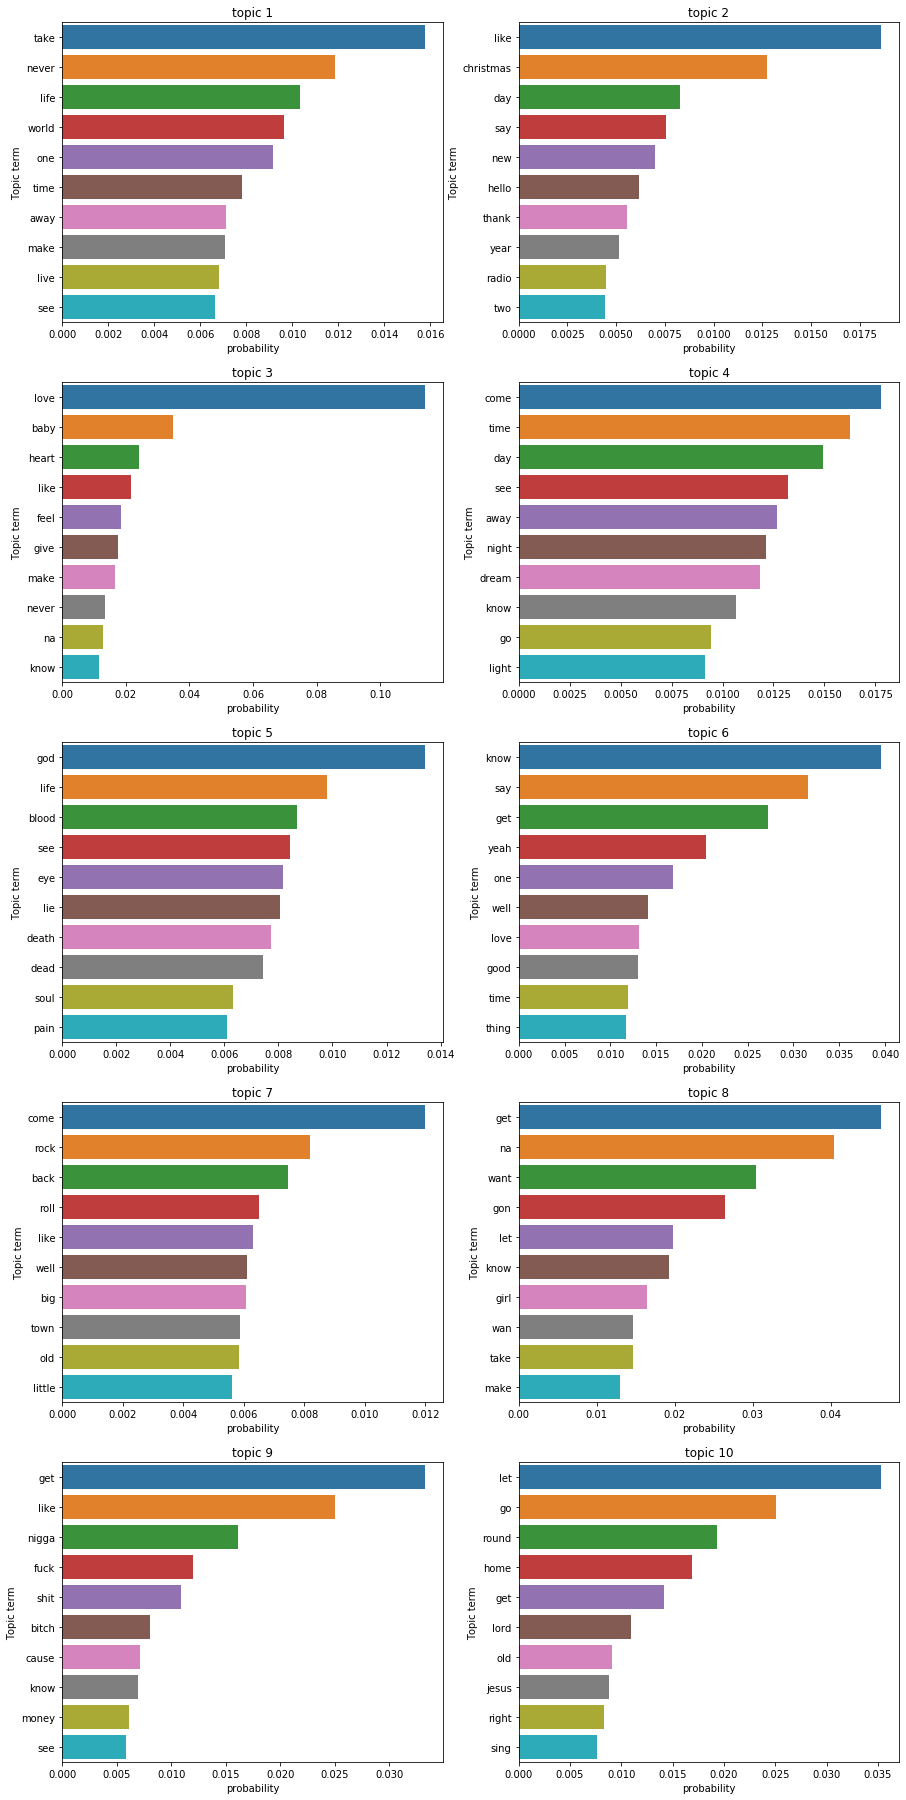

In [169]:
fig=plt.figure(figsize=(15,32))
for i in range(num_topics):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    plt.ylabel('Topic term')

### LDA visualisation with `pyLDAvis`
- LDAvis is a cool application to visualise the LDA topics and the inter-topic distances. It represents the topics as blobs on the first two principal components.

In [140]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [141]:
start = time.time()
lda_display = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)
end = time.time()
print((end-start)/3600,'hrs')

/Users/debashis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


3.172516740295622 hrs


In [143]:
pyLDAvis.display(lda_display)

### Topic modelling with LSA

LSA uses a singular value decomposition of the term-by-document matrix to identify a linear subspace in the space of tf-idf features that captures most of the variance in the collection.

In [105]:
from sklearn.decomposition import TruncatedSVD 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=42) 
svd_model.fit(train_lyrics_features) 

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=42, tol=0.0)

In [147]:
svd_model.components_.shape

(10, 50000)

In [106]:
terms = tfidf_vectorizer.get_feature_names() 
topics_lsa_dict = {}
for i, comp in enumerate(svd_model.components_): 
    terms_comp = zip(terms, comp) 
    sorted_terms = [tup[0] for tup in sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]]
    topics_lsa_dict[i] = sorted_terms

In [107]:
pd.DataFrame(topics_lsa_dict)

,0,1,2,3,4,5,6,7,8,9
0,get,nigga,blood,love,love,love,god,away,baby,yeah
1,know,get,death,baby,nigga,nigga,lord,day,say,yeah yeah
2,love,shit,nigga,night,heart,day,well,back,cry,baby
3,like,fuck,fuck,yeah,love love,love love,life,gonna,back,hey
4,say,bitch,god,light,fuck,would,one,come,lie,cry
5,see,yeah,light,love love,give,say,world,time,leave,eye
6,time,money,black,sky,life,could,people,life,home,ooh
7,come,as,soul,girl,shit,never,little,long,tear,pain
8,make,like,dead,come,need,old,jesus,home,tell,lie
9,one,hit,shit,dance,bitch,bitch,gonna,take,heart,day


## Can we predict the genre given the lyrics?
Let's find out! I have removed the *Other, R&B, Indie and Folk* genres from the dataset as part of the data cleaning process.



In [66]:
cond = (data.genre == 'Other') | (data.genre == 'Indie') | (data.genre == 'R&B') | (data.genre == 'Folk')
X = data.loc[~cond, ['year', 'artist', 'lyrics']]
y = data.loc[~cond, 'genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
ntrain = X_train.shape[0] # number of training examples

In [68]:
le = LabelBinarizer()
artist_ohe = le.fit_transform(X.artist)
artist_ohe_sparse = sparse.csr_matrix(artist_ohe)

from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaled_year = scaler.fit_transform(X.year.values.reshape(-1,1))
#scaled_year_sparse = sparse.csr_matrix(scaled_year)

In [69]:
tfidf_vectorizer = TfidfVectorizer(
    strip_accents= 'unicode', analyzer='word', max_df = 0.7, ngram_range=(1, 2), sublinear_tf=True,                                  
     max_features=50000)

In [70]:
train_lyrics_features = tfidf_vectorizer.fit_transform(X_train['lyrics'])
test_lyrics_features = tfidf_vectorizer.transform(X_test['lyrics'])

In [71]:
feature_names = tfidf_vectorizer.get_feature_names()

In [114]:
train_features_full = sparse.hstack([train_lyrics_features])
test_features_full = sparse.hstack([test_lyrics_features])

#train_features_full = sparse.hstack([train_lyrics_features, artist_ohe_sparse[:ntrain]])
#test_features_full = sparse.hstack([test_lyrics_features, artist_ohe_sparse[ntrain:]])

In [116]:
alpha_list = [0.0001, 0.0005, 0.001,0.005]

cv_alpha_dict = {}
for alpha in alpha_list:
    clf_mulNB = MultinomialNB(alpha=alpha)
    cv_score = np.mean(cross_val_score(clf_mulNB,train_features_full,y_train,cv=5,scoring='accuracy'))
    cv_alpha_dict[alpha] = cv_score   

In [117]:
pd.DataFrame(zip(cv_alpha_dict.keys(),cv_alpha_dict.values()), columns=[r'$\alpha$', 'CV score']).sort_values(by='CV score',ascending=False)

,$\alpha$,CV score
3,0.0050,0.635072
2,0.0010,0.634925
1,0.0005,0.634610
0,0.0001,0.634162


In [118]:
clf_mulNB_pred = MultinomialNB(alpha=0.005).fit(train_features_full,y_train).predict(test_features_full)

In [119]:
print(classification_report(y_test,clf_mulNB_pred))

              precision    recall  f1-score   support

     Country       0.62      0.20      0.30      4225
  Electronic       0.82      0.03      0.06      1961
     Hip-Hop       0.77      0.77      0.77      6731
        Jazz       0.50      0.26      0.34      2163
       Metal       0.67      0.59      0.63      6135
         Pop       0.51      0.31      0.38     10222
        Rock       0.64      0.86      0.73     29768

    accuracy                           0.64     61205
   macro avg       0.64      0.43      0.46     61205
weighted avg       0.63      0.64      0.60     61205



In [107]:
clf_logreg = LogisticRegression(solver='sag', multi_class='ovr')
logreg_cv_scores = cross_val_score(clf_logreg, train_features_full, y_train, cv=5)

In [108]:
np.mean(logreg_cv_scores)

0.6494757921231991

In [112]:
clf_logreg_pred = LogisticRegression(C=10, solver='sag', multi_class='ovr').fit(train_features_full,y_train).predict(test_features_full)

In [113]:
print(classification_report(y_test,clf_logreg_pred))

              precision    recall  f1-score   support

     Country       0.59      0.34      0.43      4225
  Electronic       0.59      0.09      0.16      1961
     Hip-Hop       0.87      0.81      0.84      6731
        Jazz       0.60      0.29      0.39      2163
       Metal       0.70      0.55      0.62      6135
         Pop       0.47      0.39      0.43     10222
        Rock       0.66      0.84      0.74     29768

    accuracy                           0.65     61205
   macro avg       0.64      0.47      0.51     61205
weighted avg       0.64      0.65      0.63     61205



In [148]:
genres_list = ['Pop', 'Rock', 'Metal', 'Electronic', 'Country', 'Hip-Hop', 'Jazz']
cm_logreg = confusion_matrix(y_test,clf_logreg_pred, labels = genres_list)
pd.DataFrame(cm_logreg, columns = genres_list, index = genres_list)

,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,3944,5417,140,35,202,340,144
Rock,2626,24905,1120,57,639,227,194
Metal,209,2418,3391,10,6,95,6
Electronic,358,1215,91,180,10,100,7
Country,440,2231,25,1,1449,12,67
Hip-Hop,432,763,68,15,22,5420,11
Jazz,321,1040,19,5,117,28,633


### XGBoost

In [213]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=100, max_depth=5, colsample_bytree=0.5)

In [220]:
y_train_labels = y_train.map({'Pop':1, 'Rock':2, 'Metal':3, 'Electronic':4, 'Country':5, 'Hip-Hop':6, 'Jazz':7})
y_test_labels = y_test.map({'Pop':1, 'Rock':2, 'Metal':3, 'Electronic':4, 'Country':5, 'Hip-Hop':6, 'Jazz':7})

In [222]:
clf_xgb.fit(train_features_full,y_train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [223]:
clf_xgb_pred = clf_xgb.predict(test_features_full)

In [228]:
print(classification_report(y_test_labels,clf_xgb_pred,target_names = genres_list))

              precision    recall  f1-score   support

         Pop       0.56      0.17      0.26     10222
        Rock       0.58      0.95      0.72     29768
       Metal       0.77      0.35      0.48      6135
  Electronic       0.95      0.01      0.02      1961
     Country       0.79      0.08      0.15      4225
     Hip-Hop       0.85      0.75      0.80      6731
        Jazz       0.60      0.05      0.09      2163

    accuracy                           0.62     61205
   macro avg       0.73      0.34      0.36     61205
weighted avg       0.65      0.62      0.54     61205



In [233]:
cm_xgb = confusion_matrix(y_test_labels,clf_xgb_pred)
pd.DataFrame(cm_xgb, columns = genres_list, index = genres_list)

,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,1719,8007,61,0,11,395,29
Rock,574,28323,509,0,72,262,28
Metal,43,3853,2133,0,1,104,1
Electronic,131,1694,22,21,2,91,0
Country,89,3743,15,0,356,9,13
Hip-Hop,403,1258,20,1,1,5048,0
Jazz,101,1908,10,0,9,27,108


In [211]:
np.array([tuple_weights[1] for tuple_weights in lda_tfidf[corpus_tfidf[50]]], dtype='float64')

array([0.02, 0.02, 0.02, 0.02, 0.67, 0.04, 0.02, 0.04, 0.02, 0.11])